# Classificando HPAs

Percorre os arquivos baixados por `hpa_usage.ipynb` no diretório `search_results` e classifica-os de acordo com suas características.

In [1]:
import os
import subprocess
import re
import yaml
from datetime import datetime, timedelta
from pathlib import Path

from joblib import Parallel, delayed
from dotenv import dotenv_values
from ghapi.core import GhApi, HTTP422UnprocessableEntityError, HTTP404NotFoundError, HTTP403ForbiddenError
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

pd.set_option('display.max_colwidth', 2000)

# Tema padrão para os gráficos
plt.style.use('bmh')


## Definição de funções

In [2]:
def is_helm_template(content):
    # Detects Helm template patterns in the file content
    return bool(re.search(r'{{.*}}', content))


def parse_yaml_documents(content):
    # Parses YAML content into a list of documents
    try:
        return list(yaml.safe_load_all(content))
    except yaml.YAMLError:
        return []


def extract_metrics_from_spec(spec, debug=False):
    # Extracts metric information from the HPA spec
    metrics_info = []
    metrics = spec.get('metrics', [])
    if debug:
        print("Extracting metrics")
        print(metrics)

    for metric in metrics:
        if isinstance(metric, str):
            metrics_info.append({
                'Metric Name': metric,
                'Metric Type': metric,
                'Target Value': metrics[metric]
            })
        elif not 'type' in metric:
            metrics_info.append({
                'Metric Name': 'CPUUtilizationPercentage',
                'Metric Type': 'CPUUtilizationPercentage',
                'Target Value': spec['CPUUtilizationPercentage']
            })
        else:
            if debug:
                print(f"type {metric.get('type', 'NA')}")
            metric_type = metric.get('type', '')
            metric_details = metric.get(metric_type.lower(), {})
            target = metric_details.get('target', {})
            target_value = target.get('averageValue') or target.get(
                'averageUtilization') or target.get('targetAverageUtilization') or target.get('value')

            metric_name = ''
            if metric_type.lower() == 'resource':
                metric_name = metric_details.get('name', '')
            else:
                metric_name = metric_details.get('metric', {}).get('name', '')

            metrics_info.append({
                'Metric Name': metric_name,
                'Metric Type': metric_type,
                'Target Value': target_value
            })
    if not metrics:
        if 'targetCPUUtilizationPercentage' in spec:
            metrics_info.append({
                'Metric Name': 'targetCPUUtilizationPercentage',
                'Metric Type': 'targetCPUUtilizationPercentage',
                'Target Value': spec['targetCPUUtilizationPercentage']
            })
        if 'cpuUtilization' in spec:
            if debug:
                print(spec['cpuUtilization'].keys())
            metrics_info.append({
                'Metric Name': 'cpuUtilization',
                'Metric Type': 'cpuUtilization',
                'Target Value': spec['cpuUtilization']['targetPercentage']
            })
    return metrics_info


def extract_behavior_from_spec(spec, debug=False):

    behavior = spec.get('behavior', None)
    if behavior is None:
        return None

    scale_up = behavior.get('scaleUp', None)
    scale_down = behavior.get('scaleDown', None)

    if debug:
        print(f"scale_up: {scale_up}")
        print(f"scale_down: {scale_down}")

    if scale_up == None and scale_down == None:
        return None

    result = {
        "scaleUp": None,
        "scaleDown": None
    }

    if scale_up:
        result["scaleUp"] = {
            "stab_window": scale_up.get('stabilizationWindowSeconds', None),
            "select_pol": scale_up.get('selectPolicy', None),
            "policies": [{
                "type": p.get('type', ''),
                "value": p.get('value', 0),
                "periodSeconds": p.get('periodSeconds', 0)
            } for p in scale_up.get('policies', [])]
        }

    if scale_down:
        result["scaleDown"] = {
            "stab_window": scale_down.get('stabilizationWindowSeconds', None),
            "select_pol": scale_down.get('selectPolicy', None),
            "policies": [{
                "type": p.get('type', ''),
                "value": p.get('value', 0),
                "periodSeconds": p.get('periodSeconds', 0)
            } for p in scale_down.get('policies', [])]
        }

    return result


def process_yaml_content(content, debug=False):
    helm_template = is_helm_template(content)

    if helm_template:
        return [{
            'hpa_count': 0,
            'apiVersion': None,
            'Is Helm Template': True
        }]

    documents = parse_yaml_documents(content)
    if debug:
        print(f"Found {len(documents)} documents")
    hpa_definitions = []

    for doc in documents:
        if isinstance(doc, dict) and doc.get('kind') == 'HorizontalPodAutoscaler':
            if debug:
                print(f"Found hpa #{len(hpa_definitions)+1}")
            api_version = doc.get('apiVersion', '')
            spec = doc.get('spec', {})

            metrics = extract_metrics_from_spec(spec, debug)
            behavior = extract_behavior_from_spec(spec, debug)
            if debug:
                print(f"with {len(metrics)} metrics")
            hpa_definitions.append({
                'hpa_count': len(hpa_definitions)+1,
                'apiVersion': api_version,
                'Is Helm Template': helm_template,
                'Metrics': metrics,
                'Behavior': behavior
            })
    return hpa_definitions


def process_yaml_file(file_path, debug=False):
    # Processes a single YAML file to extract HPA definitions and metrics
    if debug:
        print(f"Processing {file_path}")
    with open(file_path, 'r') as f:
        content = f.read()
        return process_yaml_content(content, debug=debug)


def map_version(api_version):
    # Etiqueta versão do HPA
    # Tudo que contém 'v1' e não contém 'v2' será considerado v1.
    # Caso contrário, consideramos v2.
    if 'v1' in api_version and 'v2' not in api_version:
        return 'v1'
    else:
        return 'v2'


def add_labels(plt, x, y, hpadding=0):
    for i in range(len(x)):
        plt.text(i, y[i]+hpadding, y[i], ha='center')


def wait_for_reset(resource):
    limit = github.rate_limit.get()['resources'][resource]
    reset_time = datetime.fromtimestamp(limit['reset'])
    now = datetime.today().replace(microsecond=0)
    if limit['remaining'] <= 1:
        sleep_duration = reset_time - now
        if sleep_duration.total_seconds() < 0:
            sleep_duration = timedelta(seconds=60)
        print(f"Waiting for {sleep_duration.total_seconds()} seconds")
        time.sleep(sleep_duration.total_seconds())


def get_repo_details(row):
    wait_for_reset('core')

    owner = row['Owner']
    repo = row['Project']

    try:
        repo_details = github.repos.get(owner=owner, repo=repo)
    except HTTP403ForbiddenError:
        print("Limit reached")
        wait_for_reset('core')
        repo_details = github.repos.get(owner=owner, repo=repo)
    except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
        return {
            'stargazers_count': None,
            'created_at': None,
            'pushed_at': None
        }

    data = {
        'stargazers_count': repo_details['stargazers_count'],
        'created_at': repo_details['created_at'],
        'pushed_at': repo_details['pushed_at']
    }

    return pd.DataFrame(data=data, index=[row.name])


def get_file_commits(row):
    wait_for_reset('core')

    # 'File Path' representa o arquivo local, necessário extrair o caminho dele no repositório
    root_dir = "search_results"
    owner = row['Owner']
    repo = row['Project']
    file_path = row['File Path']
    local_path = Path(root_dir, owner, repo)
    path = Path(file_path).relative_to(local_path)

    try:
        commits = github.repos.list_commits(owner=owner, repo=repo, path=path)
    except HTTP403ForbiddenError:
        print("Limit reached")
        wait_for_reset('core')
        commits = github.repos.list_commits(owner=owner, repo=repo, path=path)
    except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
        return {
            'file_committed_at': None,
            'message': None
        }

    return commits


def get_file_last_commit(row):
    commits = get_file_commits(row)

    if len(commits) == 0:
        return {
            'file_committed_at': None,
            'message': None
        }

    data = {
        'file_committed_at': commits[0]['commit']['author']['date'],
        'message': commits[0]['commit']['message']
    }

    return pd.DataFrame(data=data, index=[row.name])


## Processamento dos arquivos HPA

In [3]:
metrics_data = []
behavior_data = []
root_dir = 'search_results'
processing_failed = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)

        rel_path = os.path.relpath(dirpath, root_dir)
        path_parts = rel_path.split(os.sep)

        owner = None
        project = None
        rest = None

        if len(path_parts) >= 2:
            owner = path_parts[0]
            project = path_parts[1]
            rest = os.sep.join(path_parts[2:])
        file_subpath = os.path.join(rest, filename)

        try:
            hpa_definitions = process_yaml_file(file_path)
        except:
            print(f"Error processing {file_path}")
            hpa_definitions = []
        for hpa in hpa_definitions:
            has_behavior = 'Behavior' in hpa and hpa['Behavior'] is not None
            # metrics
            if not 'Metrics' in hpa:
                metrics_data.append({
                    'Owner': owner,
                    'Project': project,
                    'File Path': file_path,
                    'hpa_count': hpa['hpa_count'],
                    'apiVersion': hpa['apiVersion'],
                    'Is Helm Template': hpa['Is Helm Template'],
                    'Metric Name': None,
                    'Metric Type': None,
                    'Target Value': None,
                    'Has Behavior': has_behavior
                })
            else:
                metrics = hpa['Metrics']
                for metric in metrics:
                    metrics_data.append({
                        'Owner': owner,
                        'Project': project,
                        'File Path': file_path,
                        'hpa_count': hpa['hpa_count'],
                        'apiVersion': hpa['apiVersion'],
                        'Is Helm Template': hpa['Is Helm Template'],
                        'Metric Name': metric['Metric Name'],
                        'Metric Type': metric['Metric Type'],
                        'Target Value': metric['Target Value'],
                        'Has Behavior': has_behavior
                    })
                if not metrics:
                    metrics_data.append({
                        'Owner': owner,
                        'Project': project,
                        'File Path': file_path,
                        'hpa_count': hpa['hpa_count'],
                        'apiVersion': hpa['apiVersion'],
                        'Is Helm Template': hpa['Is Helm Template'],
                        'Metric Name': None,
                        'Metric Type': None,
                        'Target Value': None,
                        'Has Behavior': has_behavior
                    })
        if not hpa_definitions:
            processing_failed.append(file_path)
            metrics_data.append({
                'Owner': owner,
                'Project': project,
                'File Path': file_path,
                'Is Helm Template': None,
                'Metric Name': None,
                'Metric Type': None,
                'Target Value': None,
                'Has Behavior': False
            })

# display(processing_failed)


Error processing search_results/Eldarrin/deepsea/src/main/fabric8/HorizontalPodAutoscaler.yml


In [4]:
df = pd.DataFrame(metrics_data)

df['hpa_count'] = df['hpa_count'].fillna(0).apply(lambda x: int(x))

display(df)


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior
0,0GiS0,tour-of-heroes-gitops-demos,search_results/0GiS0/tour-of-heroes-gitops-demos/helm/tour-of-heroes-chart/charts/api/templates/hpa.yaml,0,None,True,None,None,None,False
1,0hlov3,charts,search_results/0hlov3/charts/charts/element-web/templates/hpa.yaml,0,None,True,None,None,None,False
2,18F,identity-dashboard,search_results/18F/identity-dashboard/dockerfiles/application.yaml,0,None,True,None,None,None,False
3,18F,identity-loadtest,search_results/18F/identity-loadtest/coredns.yaml,1,autoscaling/v2,False,cpu,Resource,70,False
4,18F,identity-pki,search_results/18F/identity-pki/k8files/application.yaml,0,None,True,None,None,None,False
...,...,...,...,...,...,...,...,...,...,...
1515,zilliztech,milvus-operator,search_results/zilliztech/milvus-operator/config/samples/hpa.yaml,1,autoscaling/v2,False,memory,Resource,60,True
1516,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,1,autoscaling/v2beta1,False,cpu,Resource,None,False
1517,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,2,autoscaling/v2beta1,False,memory,Resource,None,False
1518,zuisong,vertx-server-push,search_results/zuisong/vertx-server-push/k8s.yml,0,NaN,None,None,None,None,False


## Filtra as entradas relativas a Templates Helm

No geral, estes arquivos não apresentam _metrics_ nem _behaviors_, e os valores destas propriedades são definidos nos arquivos _values.yml_ do chart.

In [5]:
filter_nohelm = df[df['Is Helm Template'] == False]

display(filter_nohelm)


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior
3,18F,identity-loadtest,search_results/18F/identity-loadtest/coredns.yaml,1,autoscaling/v2,False,cpu,Resource,70,False
12,Abxtracted,abxtracted,search_results/Abxtracted/abxtracted/k8s/hpa.yml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,85,False
16,Ahoo-Wang,CoSec,search_results/Ahoo-Wang/CoSec/k8s/cosec-gateway-hpa.yaml,1,autoscaling/v2,False,cpu,Resource,600,False
17,AhmadRafiee,DevOps_Certification,search_results/AhmadRafiee/DevOps_Certification/kubernetes/scenario/auto-scaling/php-app/04.php-hpa.yml,1,autoscaling/v2,False,cpu,Resource,50,True
18,AhmadRafiee,DevOps_Certification,search_results/AhmadRafiee/DevOps_Certification/kubernetes/scenario/auto-scaling/php-app/04.php-hpa.yml,1,autoscaling/v2,False,memory,Resource,30,True
...,...,...,...,...,...,...,...,...,...,...
1514,zilliztech,milvus-operator,search_results/zilliztech/milvus-operator/config/samples/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,True
1515,zilliztech,milvus-operator,search_results/zilliztech/milvus-operator/config/samples/hpa.yaml,1,autoscaling/v2,False,memory,Resource,60,True
1516,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,1,autoscaling/v2beta1,False,cpu,Resource,None,False
1517,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,2,autoscaling/v2beta1,False,memory,Resource,None,False


## Números Gerais dos dados encontrados

In [6]:
print("Após remover os templates helm, restaram")
print(f"{filter_nohelm[['Owner', 'Project', 'File Path', 'hpa_count', 'apiVersion']].drop_duplicates().shape[0]} definições HPA")
print(
    f"em {filter_nohelm[['Owner', 'Project', 'File Path']].drop_duplicates().shape[0]} arquivos")
print(
    f"de {filter_nohelm[['Owner', 'Project']].drop_duplicates().shape[0]} projetos")
print(
    f"por {filter_nohelm['Owner'].drop_duplicates().shape[0]} autores (owners)")
print(
    f"{filter_nohelm[filter_nohelm['Has Behavior']!=False].shape[0]} definições HPA apresentam behavior")


Após remover os templates helm, restaram
594 definições HPA
em 458 arquivos
de 358 projetos
por 333 autores (owners)
57 definições HPA apresentam behavior


# Dados sobre os Arquivos e Definições HPA encontradas

## Quantidades de Arquivos por Projeto

,,File Path
Owner,Project,
rytswd,get-istio-multicluster,7


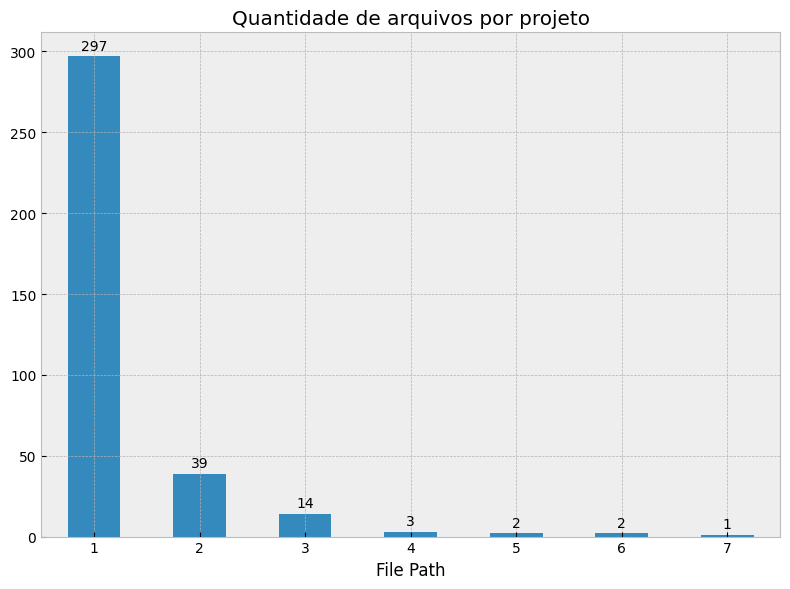

In [20]:
files_per_project = filter_nohelm[[
    'Owner', 'Project', 'File Path']].drop_duplicates()

files_counts = files_per_project.groupby(['Owner', 'Project']).count()

files_counts_values = files_counts['File Path'].value_counts()

display(files_counts[files_counts['File Path'] == 7])

plt.figure(figsize=(8, 6))

ax = files_counts_values.plot(
    kind='bar', stacked=True, ax=plt.gca())
ax.tick_params(axis="x", rotation=0)
add_labels(plt, files_counts_values.index,
           files_counts_values.values, hpadding=4)
plt.title("Quantidade de arquivos por projeto")
plt.tight_layout()
plt.show()


A maioria dos projetos tem apenas 1 arquivo com definição HPA

## Versões de HPA encontradas

'594'

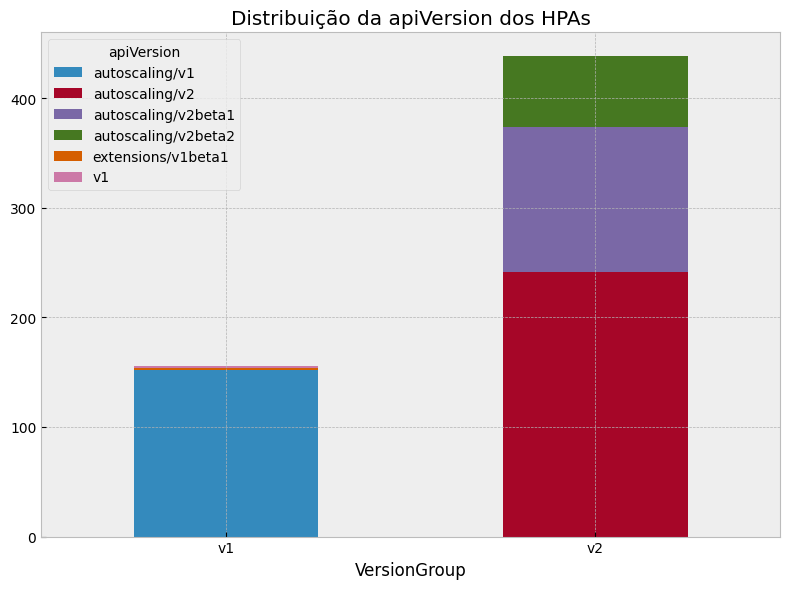

apiVersion,autoscaling/v1,autoscaling/v2,autoscaling/v2beta1,autoscaling/v2beta2,extensions/v1beta1,v1,Total
VersionGroup,,,,,,,
v1,152.0,0.0,0.0,0.0,2.0,2.0,156.0
v2,0.0,241.0,133.0,64.0,0.0,0.0,438.0


In [21]:
df_hpa_defs = filter_nohelm[[
    'Owner', 'Project', 'File Path', 'hpa_count', 'apiVersion']].drop_duplicates()

display(f"{df_hpa_defs.shape[0]}")

version_counts = df_hpa_defs['apiVersion'].value_counts().sort_index()
df_grouped = pd.DataFrame(
    {'apiVersion': version_counts.index, 'count': version_counts.values})

df_grouped['VersionGroup'] = df_grouped['apiVersion'].apply(func=map_version)

pivot_versions = df_grouped.pivot(
    index='VersionGroup', columns='apiVersion', values='count').fillna(0)

plt.figure(figsize=(8, 6))
ax = pivot_versions.plot(kind='bar', stacked=True, ax=plt.gca())
# add_labels(plt, pivot_versions.index, pivot_versions.values, hpadding=4)
ax.tick_params(axis="x", rotation=0)
plt.title("Distribuição da apiVersion dos HPAs")
plt.tight_layout()
plt.show()

pivot_versions['Total'] = pivot_versions.sum(axis=1)
display(pivot_versions)


Das definições HPA encontradas, cerca de 26% estão utilizando a versão v1 enquanto cerca de 74% utilizam a versão v2 em alguma de suas variações (v2beta1 ou v2beta2).

## Definições de HPA por arquivo

Em alguns projetos, um único arquivo yaml pode ter várias definições de HPA.

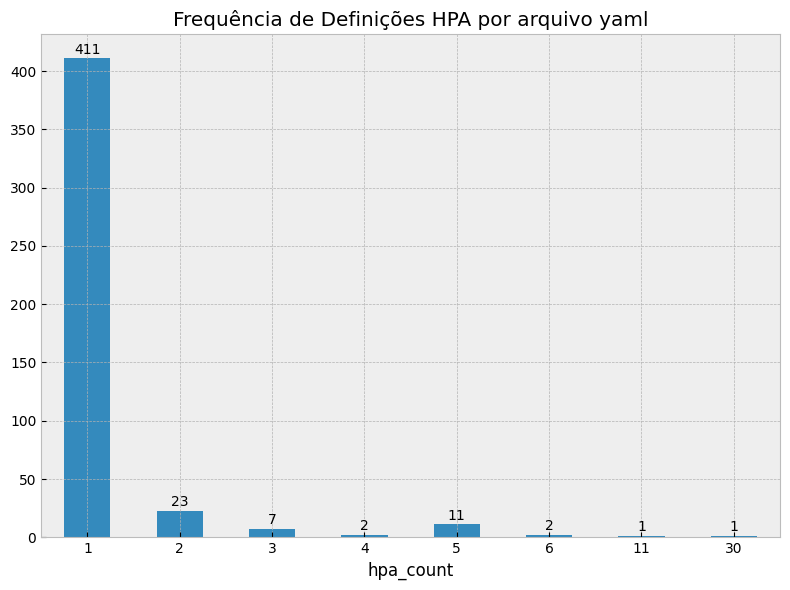

1332    search_results/solo-io/service-mesh-for-less-blog/tiered-app/30-namespace-app/ambient/waypoints/hpa-per-namespace.yaml
Name: File Path, dtype: object

1467    search_results/vigsachi/erlang/models/online_boutique/mem_autoscale/mem_autoscale_30.yaml
Name: File Path, dtype: object

In [22]:
filter_nohelm_nodups = (
    filter_nohelm
    .sort_values('hpa_count', ascending=False)
    .drop_duplicates(subset=['Owner', 'Project', 'File Path'], keep='first')
)

hpa_counts = filter_nohelm_nodups['hpa_count'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
ax = hpa_counts.plot(kind='bar')
add_labels(plt, hpa_counts.index, hpa_counts.values, hpadding=4)
ax.tick_params(axis="x", rotation=0)
plt.title("Frequência de Definições HPA por arquivo yaml")
plt.tight_layout()
plt.show()

display(
    filter_nohelm_nodups[filter_nohelm_nodups['hpa_count'] == 30]['File Path'])
display(
    filter_nohelm_nodups[filter_nohelm_nodups['hpa_count'] == 11]['File Path'])


Dos 458 arquivos identificados, 411 contém apenas 1 definição HPA. Alguns projetos apresentam arquivos com até 30 definições HPA.

## Tipos de métrica por definição HPA

23 definições HPA não apresentam métricas (usam os valores padrão)


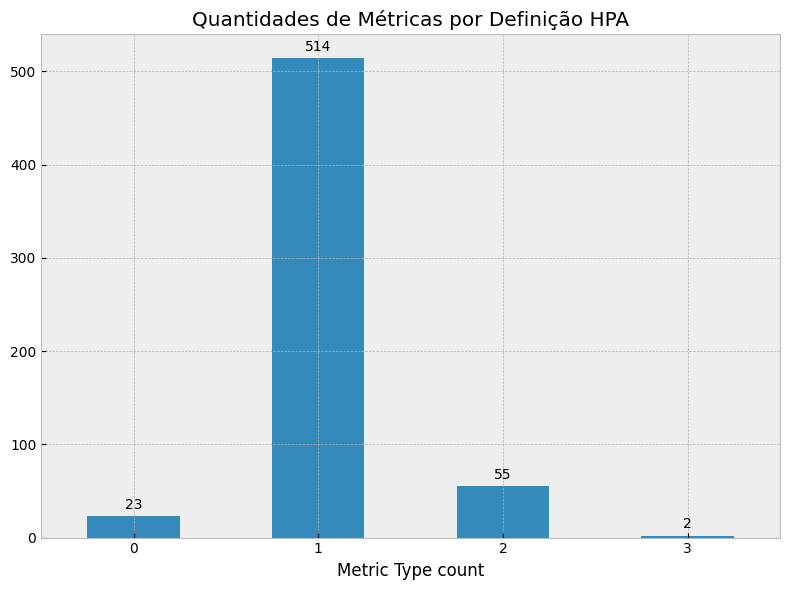

154    search_results/arafkarsh/k8s-quickstart/colima/Yamls/app/fusion-12-water-product-hpa-green.yaml
416                 search_results/ptrstpp950/k8s-allegro/exercises/28-kctl-hpa-scaling/template2.yaml
Name: File Path, dtype: object


In [8]:
files_n_def = filter_nohelm[['File Path', 'hpa_count']].drop_duplicates()
# display(files_n_def.shape[0])

metrics_per_def = filter_nohelm.groupby(['File Path', 'hpa_count'])[
    'Metric Type'].count().reset_index(name='Metric Type count')

zero_metrics = metrics_per_def[metrics_per_def['Metric Type count'] == 0]
# display(zero_metrics)
print(
    f"{zero_metrics.shape[0]} definições HPA não apresentam métricas (usam os valores padrão)")

metrics_counts = metrics_per_def['Metric Type count'].value_counts(
).sort_index()

plt.figure(figsize=(8, 6))
ax = metrics_counts.plot(kind='bar')
add_labels(plt, metrics_counts.index, metrics_counts.values, hpadding=8)
ax.tick_params(axis="x", rotation=0)
plt.title("Quantidades de Métricas por Definição HPA")
plt.tight_layout()
plt.show()

print(metrics_per_def[metrics_per_def['Metric Type count'] == 3]['File Path'])


# Tipos de Métricas

Investigando quais tipos de métricas são mais utilizadas, e quais métricas além das mais comuns (CPU e memória) são populares.

Para este passo, serão consideradas apenas as definições v2, já que as v1 contém apenas CPU e memória.

497

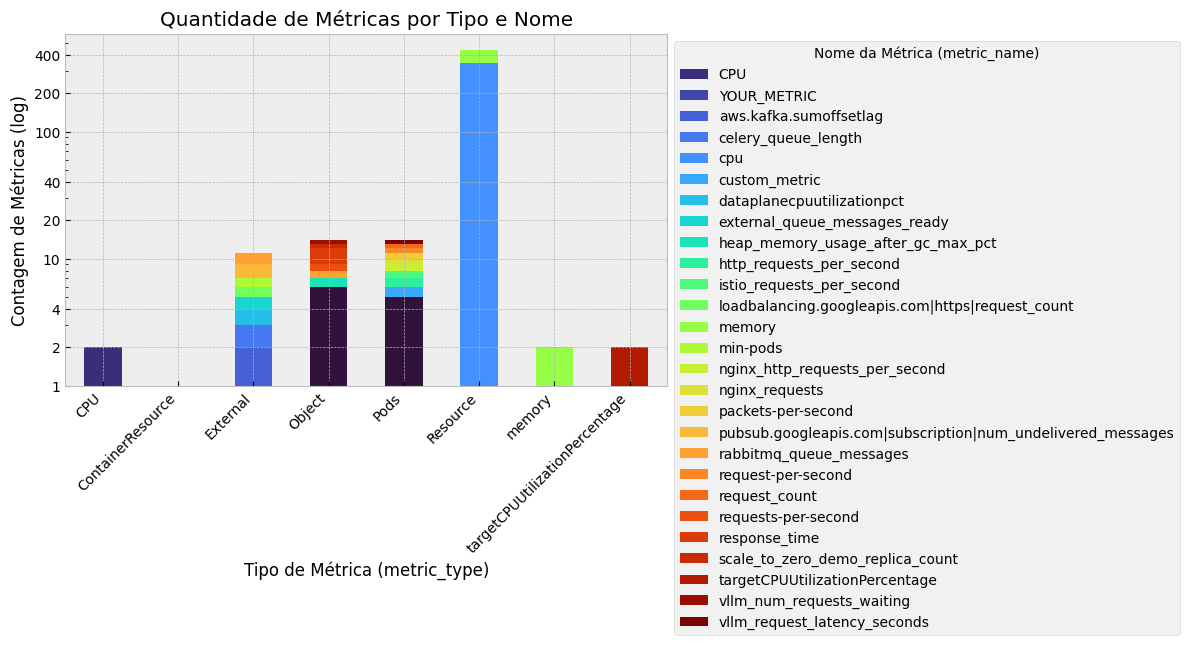

In [24]:
from matplotlib.ticker import LogLocator, FormatStrFormatter
df_v2 = filter_nohelm[filter_nohelm['apiVersion'].str.contains('v2')]
display(df_v2.shape[0])

v2_metrics = df_v2.groupby(
    ['Metric Type', 'Metric Name']).size().reset_index(name='counts')

pivot_table = v2_metrics.pivot(
    index='Metric Type', columns='Metric Name', values='counts').fillna(0)


fig = plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='turbo')
ax = plt.gca()
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base=10, subs=[1, 2, 4]))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.title('Quantidade de Métricas por Tipo e Nome')
plt.xlabel('Tipo de Métrica (metric_type)')
plt.ylabel('Contagem de Métricas (log)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nome da Métrica (metric_name)', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


As métricas do tipo Resource ofuscam os outros tipos devido à sua popularidade. O tipo ContainerResource apresenta 1 métrica que está escondida devido a escala logarítmica.

Abaixo são apresentados os mesmos valores removendo este tipo de métrica e utilizando escala linear.

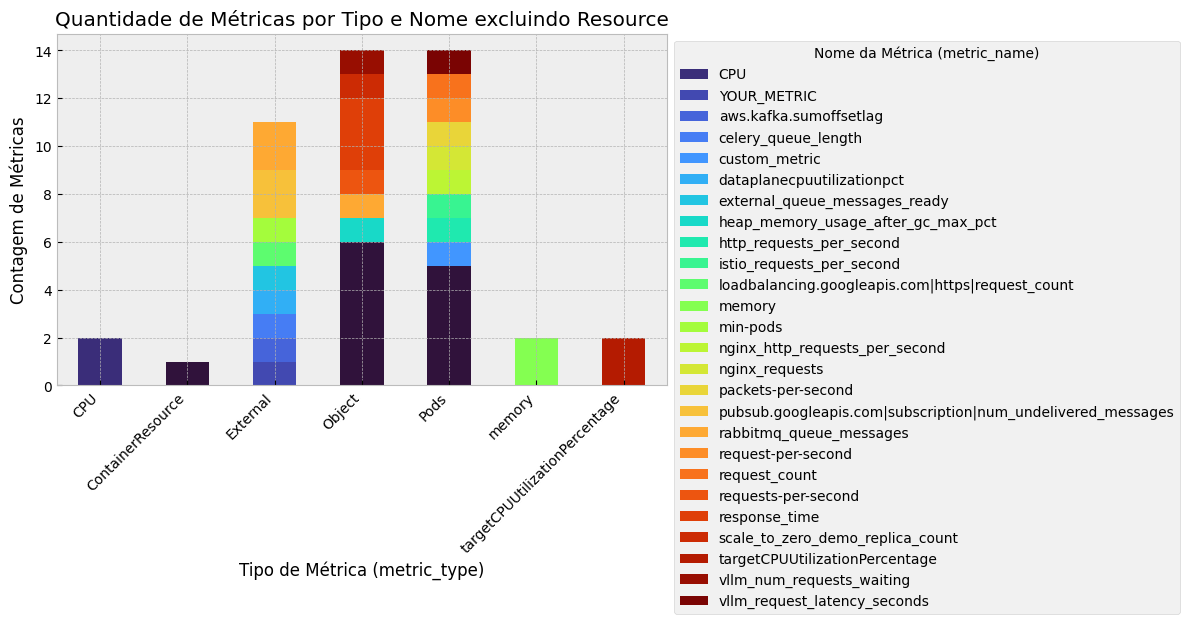

In [25]:
df_v2 = filter_nohelm[filter_nohelm['apiVersion'].str.contains('v2')]

df_v2_no_resource = df_v2[df_v2['Metric Type'] != 'Resource']

# display(df_v2_no_resource[df_v2_no_resource['Metric Type'] == 'External'])

v2_metrics = df_v2_no_resource.groupby(
    ['Metric Type', 'Metric Name']).size().reset_index(name='counts')

pivot_table = v2_metrics.pivot(
    index='Metric Type', columns='Metric Name', values='counts').fillna(0)

plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='turbo')
plt.title('Quantidade de Métricas por Tipo e Nome excluindo Resource')
plt.xlabel('Tipo de Métrica (metric_type)')
plt.ylabel('Contagem de Métricas')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nome da Métrica (metric_name)', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


# Commits dos Projetos e Arquivos

Buscar relações entre as datas de criação dos projetos, últimos commits neles e últimos commits nos arquivos

In [9]:
config = {
    **os.environ,
    **dotenv_values(".env")
}
github = GhApi(token=config['GITHUB_TOKEN'])


Dados do repositório

In [10]:
wait_for_reset('core')

repos_details = Parallel(n_jobs=32)(
    delayed(get_repo_details)(row) for _, row in filter_nohelm.iterrows()
)


In [11]:
df_details = pd.concat(repos_details)
display(df_details)


,stargazers_count,created_at,pushed_at
3,3,2020-03-24T18:34:02Z,2025-03-26T19:26:26Z
12,2,2016-11-09T22:46:26Z,2018-03-14T16:37:40Z
16,35,2022-11-19T05:52:15Z,2025-03-25T23:29:44Z
17,263,2022-09-08T09:13:16Z,2025-03-22T08:24:00Z
18,263,2022-09-08T09:13:16Z,2025-03-22T08:24:00Z
...,...,...,...
1514,69,2023-08-08T03:02:18Z,2025-03-24T11:43:14Z
1515,69,2023-08-08T03:02:18Z,2025-03-24T11:43:14Z
1516,10,2022-06-06T09:46:12Z,2025-02-08T06:13:19Z
1517,10,2022-06-06T09:46:12Z,2025-02-08T06:13:19Z


Dados de commit do arquivo que contém HPA

In [12]:
wait_for_reset('core')

paths_committed_at = Parallel(n_jobs=32)(
    delayed(get_file_last_commit)(row) for _, row in filter_nohelm.iterrows()
)


In [13]:
df_committed_at = pd.concat(paths_committed_at)
display(df_committed_at)


,file_committed_at,message
3,2025-02-25T23:47:31Z,increase HPA cpu threshold of coredns
12,2017-05-18T03:29:08Z,domain cookie fix
16,2023-06-20T01:58:18Z,Remove cosky dependency (#174)
17,2025-02-23T09:08:31Z,Change kubernetes add-ons and auto scaling scenraio
18,2025-02-23T09:08:31Z,Change kubernetes add-ons and auto scaling scenraio
...,...,...
1514,2024-11-19T09:57:39Z,chart: make webhook optional\n\nSigned-off-by: haorenfsa <shaoyue.chen@zilliz.com>
1515,2024-11-19T09:57:39Z,chart: make webhook optional\n\nSigned-off-by: haorenfsa <shaoyue.chen@zilliz.com>
1516,2023-02-23T07:40:16Z,feat✨(swagger): add missing files\n\nSigned-off-by: zjzzzjjj <zjzjzjzj1874@gmail.com>
1517,2023-02-23T07:40:16Z,feat✨(swagger): add missing files\n\nSigned-off-by: zjzzzjjj <zjzjzjzj1874@gmail.com>


Join dos dados obtidos com o filter_nohelm em um novo DataFrame

In [14]:
items_details = filter_nohelm.join([df_details, df_committed_at])

display(items_details)


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior,stargazers_count,created_at,pushed_at,file_committed_at,message
3,18F,identity-loadtest,search_results/18F/identity-loadtest/coredns.yaml,1,autoscaling/v2,False,cpu,Resource,70,False,3,2020-03-24T18:34:02Z,2025-03-26T19:26:26Z,2025-02-25T23:47:31Z,increase HPA cpu threshold of coredns
12,Abxtracted,abxtracted,search_results/Abxtracted/abxtracted/k8s/hpa.yml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,85,False,2,2016-11-09T22:46:26Z,2018-03-14T16:37:40Z,2017-05-18T03:29:08Z,domain cookie fix
16,Ahoo-Wang,CoSec,search_results/Ahoo-Wang/CoSec/k8s/cosec-gateway-hpa.yaml,1,autoscaling/v2,False,cpu,Resource,600,False,35,2022-11-19T05:52:15Z,2025-03-25T23:29:44Z,2023-06-20T01:58:18Z,Remove cosky dependency (#174)
17,AhmadRafiee,DevOps_Certification,search_results/AhmadRafiee/DevOps_Certification/kubernetes/scenario/auto-scaling/php-app/04.php-hpa.yml,1,autoscaling/v2,False,cpu,Resource,50,True,263,2022-09-08T09:13:16Z,2025-03-22T08:24:00Z,2025-02-23T09:08:31Z,Change kubernetes add-ons and auto scaling scenraio
18,AhmadRafiee,DevOps_Certification,search_results/AhmadRafiee/DevOps_Certification/kubernetes/scenario/auto-scaling/php-app/04.php-hpa.yml,1,autoscaling/v2,False,memory,Resource,30,True,263,2022-09-08T09:13:16Z,2025-03-22T08:24:00Z,2025-02-23T09:08:31Z,Change kubernetes add-ons and auto scaling scenraio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,zilliztech,milvus-operator,search_results/zilliztech/milvus-operator/config/samples/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,True,69,2023-08-08T03:02:18Z,2025-03-24T11:43:14Z,2024-11-19T09:57:39Z,chart: make webhook optional\n\nSigned-off-by: haorenfsa <shaoyue.chen@zilliz.com>
1515,zilliztech,milvus-operator,search_results/zilliztech/milvus-operator/config/samples/hpa.yaml,1,autoscaling/v2,False,memory,Resource,60,True,69,2023-08-08T03:02:18Z,2025-03-24T11:43:14Z,2024-11-19T09:57:39Z,chart: make webhook optional\n\nSigned-off-by: haorenfsa <shaoyue.chen@zilliz.com>
1516,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,1,autoscaling/v2beta1,False,cpu,Resource,None,False,10,2022-06-06T09:46:12Z,2025-02-08T06:13:19Z,2023-02-23T07:40:16Z,feat✨(swagger): add missing files\n\nSigned-off-by: zjzzzjjj <zjzjzjzj1874@gmail.com>
1517,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,2,autoscaling/v2beta1,False,memory,Resource,None,False,10,2022-06-06T09:46:12Z,2025-02-08T06:13:19Z,2023-02-23T07:40:16Z,feat✨(swagger): add missing files\n\nSigned-off-by: zjzzzjjj <zjzjzjzj1874@gmail.com>


In [82]:
releasedate_hpav1 = pd.to_datetime("2016-10-25").replace(tzinfo=None)
releasedate_hpav2 = pd.to_datetime("2021-12-07").replace(tzinfo=None)

In [93]:
details_dates = items_details[[
    'created_at', 'pushed_at', 'file_committed_at', 'apiVersion']].copy()

details_dates['created_at'] = pd.to_datetime(details_dates['created_at'])
details_dates['pushed_at'] = pd.to_datetime(details_dates['pushed_at'])
details_dates['file_committed_at'] = pd.to_datetime(
    details_dates['file_committed_at'])

details_dates['hpaVersion'] = details_dates['apiVersion'].apply(map_version)

details_dates.sort_values('pushed_at', inplace=True,
                          ignore_index=True, ascending=True)

display(details_dates)


,created_at,pushed_at,file_committed_at,apiVersion,hpaVersion
0,2016-02-04 19:20:19+00:00,2016-05-09 16:37:33+00:00,2016-02-26 20:02:40+00:00,extensions/v1beta1,v1
1,2016-09-09 20:28:54+00:00,2017-05-05 23:42:18+00:00,2017-05-05 01:18:55+00:00,autoscaling/v1,v1
2,2016-09-09 20:28:54+00:00,2017-05-05 23:42:18+00:00,2016-09-23 14:02:38+00:00,autoscaling/v1,v1
3,2017-08-18 19:28:36+00:00,2017-08-24 20:54:26+00:00,2017-08-18 19:40:14+00:00,extensions/v1beta1,v1
4,2016-11-09 22:46:26+00:00,2018-03-14 16:37:40+00:00,2017-05-18 03:29:08+00:00,autoscaling/v1,v1
...,...,...,...,...,...
648,2020-12-31 05:47:19+00:00,2025-03-27 11:16:09+00:00,2025-03-24 09:34:39+00:00,autoscaling/v2,v2
649,2020-12-31 05:47:19+00:00,2025-03-27 11:16:09+00:00,2025-03-24 09:34:39+00:00,autoscaling/v2,v2
650,2020-12-31 05:47:19+00:00,2025-03-27 11:16:09+00:00,2025-03-24 09:34:39+00:00,autoscaling/v2,v2
651,2023-07-11 13:58:33+00:00,2025-03-27 11:30:32+00:00,2025-03-25 15:05:16+00:00,autoscaling/v2,v2


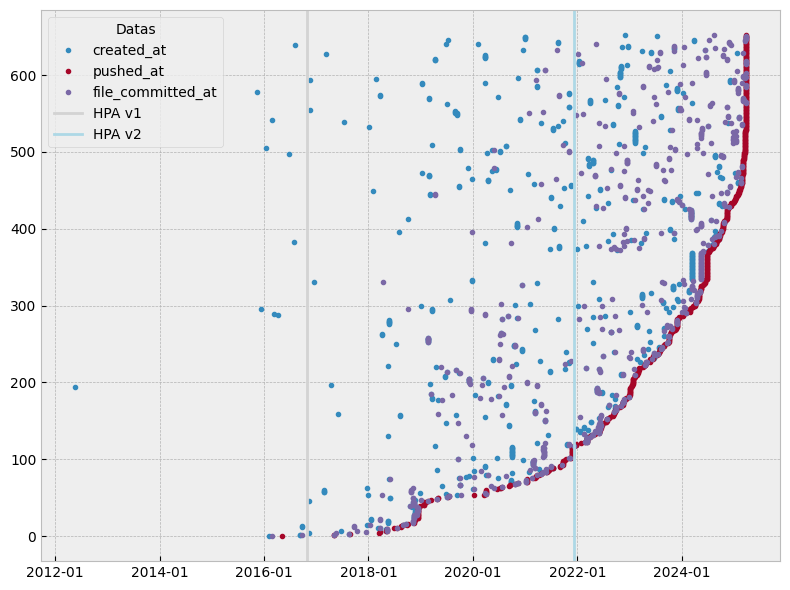

In [85]:
def dates_scatter_plot(df):
    plt.figure(figsize=(8, 6))
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

    plt.plot(df['created_at'], df.index,
            marker='.', linestyle='', label='created_at')
    plt.plot(df['pushed_at'], df.index,
            marker='.', linestyle='', label='pushed_at')
    plt.plot(df['file_committed_at'], df.index,
            marker='.', linestyle='', label='file_committed_at')
    plt.axvline(x=releasedate_hpav1, color='lightgray', label="HPA v1")
    plt.axvline(x=releasedate_hpav2, color='lightblue', label="HPA v2")

    plt.legend(title='Datas')

    plt.tight_layout()
    plt.show()

dates_scatter_plot(details_dates)


In [114]:
details_dates_active = details_dates[details_dates['pushed_at'] >= "2025-01-01"].copy().reset_index()

details_dates_active

,index,created_at,pushed_at,file_committed_at,apiVersion,hpaVersion
0,437,2023-01-24 17:36:38+00:00,2025-01-07 23:16:20+00:00,2023-02-06 11:01:02+00:00,autoscaling/v1,v1
1,438,2023-08-30 01:24:51+00:00,2025-01-09 04:55:23+00:00,2023-12-01 02:25:00+00:00,autoscaling/v2,v2
2,439,2023-08-30 01:24:51+00:00,2025-01-09 04:55:23+00:00,2023-12-01 02:25:00+00:00,autoscaling/v2,v2
3,440,2021-07-02 22:15:22+00:00,2025-01-11 23:41:15+00:00,2022-11-26 05:12:30+00:00,autoscaling/v2,v2
4,441,2021-07-02 22:15:22+00:00,2025-01-11 23:41:15+00:00,2022-11-26 05:12:30+00:00,autoscaling/v2,v2
...,...,...,...,...,...,...
211,648,2020-12-31 05:47:19+00:00,2025-03-27 11:16:09+00:00,2025-03-24 09:34:39+00:00,autoscaling/v2,v2
212,649,2020-12-31 05:47:19+00:00,2025-03-27 11:16:09+00:00,2025-03-24 09:34:39+00:00,autoscaling/v2,v2
213,650,2020-12-31 05:47:19+00:00,2025-03-27 11:16:09+00:00,2025-03-24 09:34:39+00:00,autoscaling/v2,v2
214,651,2023-07-11 13:58:33+00:00,2025-03-27 11:30:32+00:00,2025-03-25 15:05:16+00:00,autoscaling/v2,v2


In [115]:
details_dates_v2 = details_dates_active[details_dates_active['hpaVersion'] == 'v2'].copy().reset_index()

details_dates_v2

,level_0,index,created_at,pushed_at,file_committed_at,apiVersion,hpaVersion
0,1,438,2023-08-30 01:24:51+00:00,2025-01-09 04:55:23+00:00,2023-12-01 02:25:00+00:00,autoscaling/v2,v2
1,2,439,2023-08-30 01:24:51+00:00,2025-01-09 04:55:23+00:00,2023-12-01 02:25:00+00:00,autoscaling/v2,v2
2,3,440,2021-07-02 22:15:22+00:00,2025-01-11 23:41:15+00:00,2022-11-26 05:12:30+00:00,autoscaling/v2,v2
3,4,441,2021-07-02 22:15:22+00:00,2025-01-11 23:41:15+00:00,2022-11-26 05:12:30+00:00,autoscaling/v2,v2
4,7,444,2019-03-07 11:32:00+00:00,2025-01-28 17:30:25+00:00,2019-04-11 10:52:22+00:00,autoscaling/v2beta1,v2
...,...,...,...,...,...,...,...
166,211,648,2020-12-31 05:47:19+00:00,2025-03-27 11:16:09+00:00,2025-03-24 09:34:39+00:00,autoscaling/v2,v2
167,212,649,2020-12-31 05:47:19+00:00,2025-03-27 11:16:09+00:00,2025-03-24 09:34:39+00:00,autoscaling/v2,v2
168,213,650,2020-12-31 05:47:19+00:00,2025-03-27 11:16:09+00:00,2025-03-24 09:34:39+00:00,autoscaling/v2,v2
169,214,651,2023-07-11 13:58:33+00:00,2025-03-27 11:30:32+00:00,2025-03-25 15:05:16+00:00,autoscaling/v2,v2


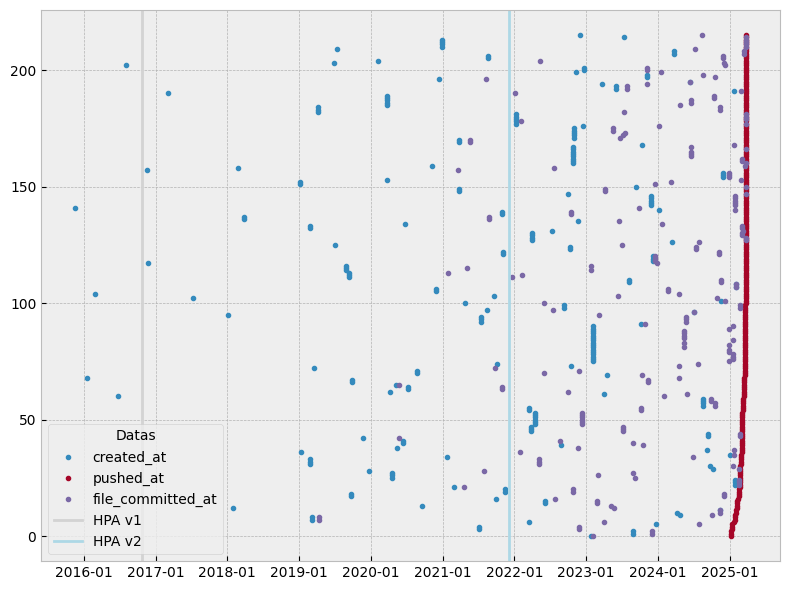

In [116]:
dates_scatter_plot(details_dates_active)#.sort_values('created_at', ignore_index=True, inplace=False, ascending=True))

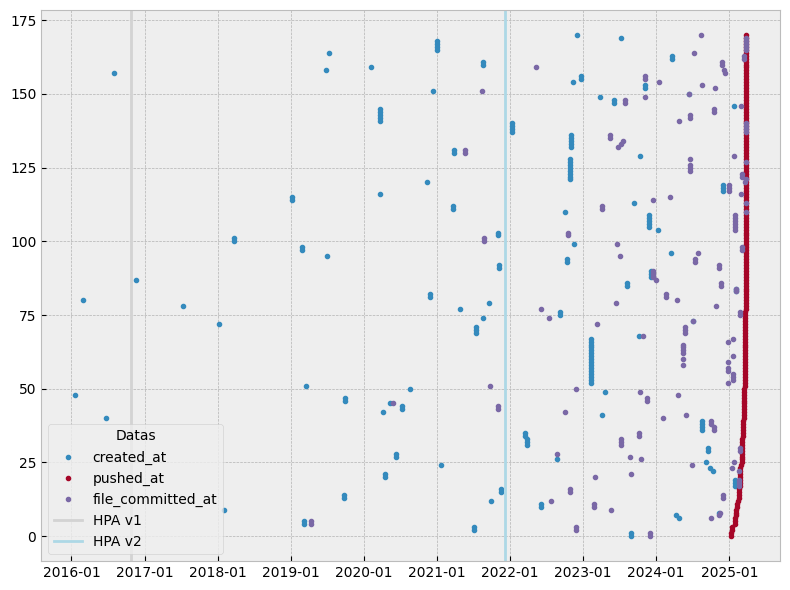

In [117]:
dates_scatter_plot(details_dates_v2)#.sort_values('created_at', ignore_index=True, inplace=False, ascending=True))

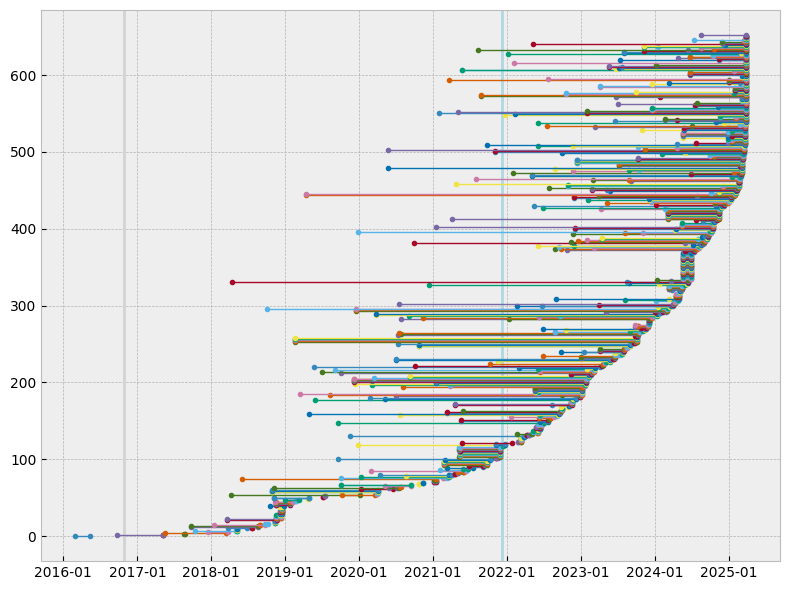

In [122]:
def timeline_plot(df):
    plt.figure(figsize=(8, 6))
    num_rows = df.shape[0]
    oldest_file_at = df['file_committed_at'].sort_values(inplace=False).iloc[0]
    if releasedate_hpav1 > oldest_file_at.replace(tzinfo=None):
        plt.axvline(x=releasedate_hpav1, color='lightgray', label="HPA v1")
    plt.axvline(x=releasedate_hpav2, color='lightblue', label="HPA v2")

    for i in df.index:
        # x1 = df.loc[i, 'created_at']
        x2 = df.loc[i, 'file_committed_at']
        x3 = df.loc[i, 'pushed_at']
        normalized_i = i / (num_rows - 1) if num_rows > 1 else 0.5
        plt.plot([x2, x3], [i, i], marker='.', linewidth=1)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.tight_layout()
    plt.show()


timeline_plot(details_dates)


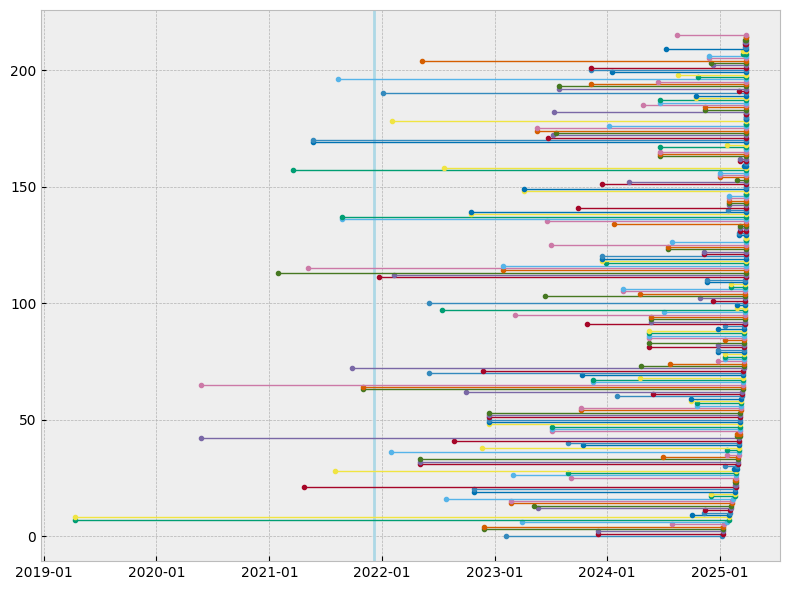

In [119]:
timeline_plot(details_dates_active)

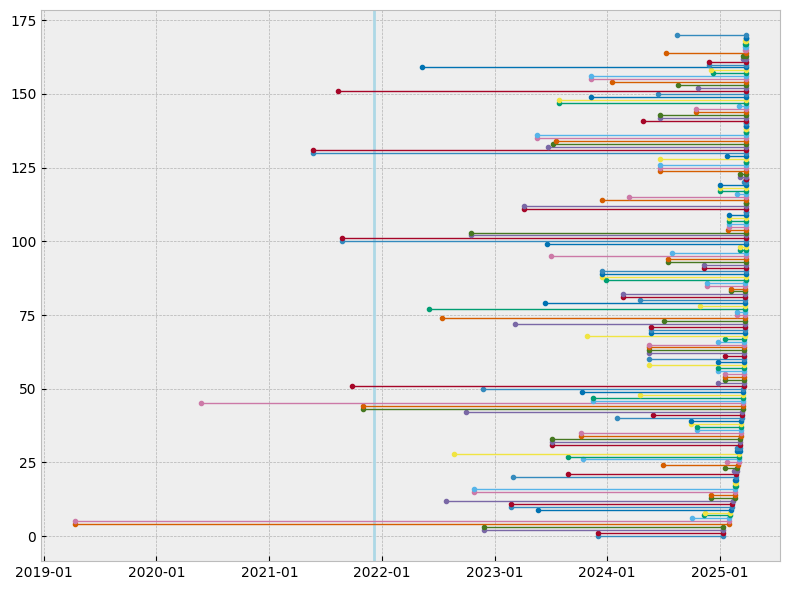

In [120]:
timeline_plot(details_dates_v2)

,pushed_at,file_committed_at


,pushed_at,file_committed_at,last_commits
3,2025-03-24 16:34:25+00:00,2025-02-25 23:47:31+00:00,26 days 16:46:54
12,2018-03-14 16:37:40+00:00,2017-05-18 03:29:08+00:00,300 days 13:08:32
16,2025-03-25 23:29:44+00:00,2023-06-20 01:58:18+00:00,644 days 21:31:26
17,2025-03-22 08:24:00+00:00,2025-02-23 09:08:31+00:00,26 days 23:15:29
18,2025-03-22 08:24:00+00:00,2025-02-23 09:08:31+00:00,26 days 23:15:29
...,...,...,...
1514,2025-03-24 11:43:14+00:00,2024-11-19 09:57:39+00:00,125 days 01:45:35
1515,2025-03-24 11:43:14+00:00,2024-11-19 09:57:39+00:00,125 days 01:45:35
1516,2025-02-08 06:13:19+00:00,2023-02-23 07:40:16+00:00,715 days 22:33:03
1517,2025-02-08 06:13:19+00:00,2023-02-23 07:40:16+00:00,715 days 22:33:03


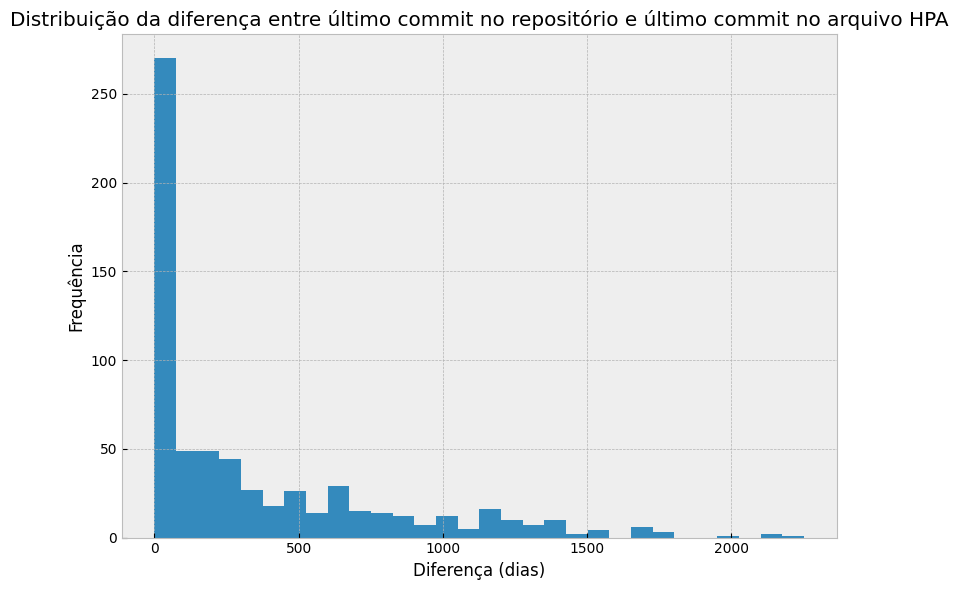

In [239]:
df_date_diff = items_details[['pushed_at', 'file_committed_at']].copy()

df_date_diff['pushed_at'] = pd.to_datetime(df_date_diff['pushed_at'])
df_date_diff['file_committed_at'] = pd.to_datetime(
    df_date_diff['file_committed_at'])

display(df_date_diff[df_date_diff['file_committed_at']
        >= df_date_diff['pushed_at']])

df_date_diff['last_commits'] = df_date_diff['pushed_at'] - \
    df_date_diff['file_committed_at']

display(df_date_diff)

plt.figure(figsize=(8, 6))

(df_date_diff['last_commits'] / pd.Timedelta(days=1)).hist(bins=30)

plt.xlabel("Diferença (dias)")
plt.ylabel("Frequência")
plt.title("Distribuição da diferença entre último commit no repositório e último commit no arquivo HPA")
plt.tight_layout()
plt.show()


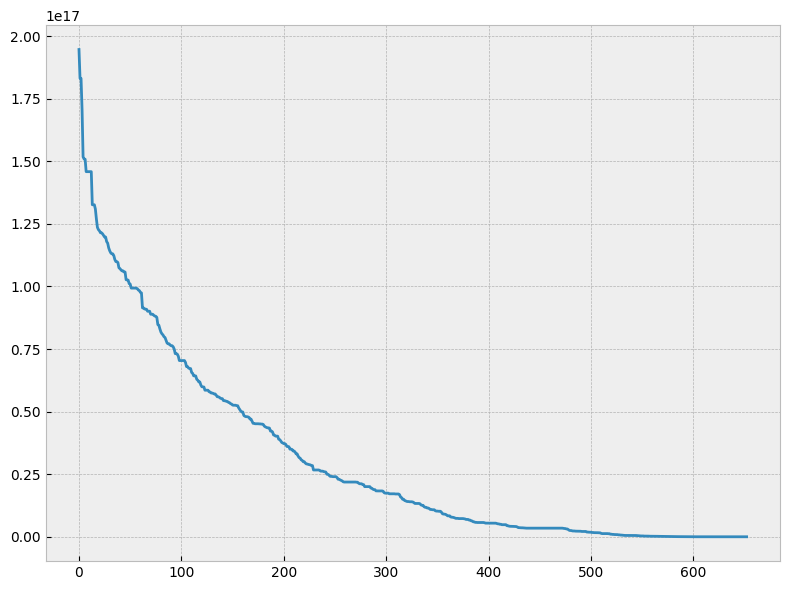

In [237]:
df_date_diff.sort_values('last_commits', inplace=True,
                         ignore_index=True, ascending=False)

cmap = plt.get_cmap('viridis')
num_rows = df_date_diff.shape[0]

plt.figure(figsize=(8, 6))

# for i in df_date_diff.index:
#     x1 = df_date_diff.loc[i, 'pushed_at']
#     x2 = df_date_diff.loc[i, 'file_committed_at']
#     normalized_i = i / (num_rows - 1) if num_rows > 1 else 0.5
#     color = cmap(normalized_i)
#     plt.plot(
#         [x1, x2], [i, i],
#         marker='.',
#         linewidth=1)#,
#         # color=color)

df_date_diff['last_commits'].plot()

plt.tight_layout()
plt.show()
